### Detekcja sylwetek ludzkich

In [16]:
from pathlib import Path
import os

import pandas as pd
from tqdm import tqdm
tqdm.pandas()

path_train = Path(r'/home/plorenc/Desktop/AiR_ISS/AVS/pedestrians')
path_test = Path(r'/home/plorenc/Desktop/AiR_ISS/AVS/Test images-pedestrians')

input_files_train = [p for p in list(path_train.rglob("*.png")) + list(path_train.rglob("*.ppm"))]
input_files_test = [p for p in path_test.glob("*.png")]

df = pd.DataFrame({'path': input_files_train})

df['label'] = df['path'].apply(lambda x: 0 if 'neg' in str(x) else 1)

df = df.sample(frac=1)

df = df.reset_index()

df.head()

,index,path,label
0,1240,/home/plorenc/Desktop/AiR_ISS/AVS/pedestrians/...,1
1,1132,/home/plorenc/Desktop/AiR_ISS/AVS/pedestrians/...,1
2,1847,/home/plorenc/Desktop/AiR_ISS/AVS/pedestrians/...,1
3,1327,/home/plorenc/Desktop/AiR_ISS/AVS/pedestrians/...,1
4,410,/home/plorenc/Desktop/AiR_ISS/AVS/pedestrians/...,0


In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve1d
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler((0, 255))

def plot(img, cmap='gray'):
    plt.figure(figsize=(10, 10))
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.show()


def compute_gradients(path):
    '''
    Oblicza gradienty obrazu w skali szarości (magnitude + angle)
    '''
    gray = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    gray = gray.astype(np.int32)

    # Gradienty w osi X i Y
    dx = convolve1d(gray, np.array([-1, 0, 1], dtype=np.float32), axis=1)
    dy = convolve1d(gray, np.array([-1, 0, 1], dtype=np.float32), axis=0)

    magnitude = np.sqrt(dx ** 2 + dy ** 2)
    angle = np.arctan2(dy, dx)
    angle[angle < 0] += np.pi  # zakres 0–π
    angle = np.rad2deg(angle)  # na stopnie

    return magnitude, angle

def create_hist(magnitude, angle, window_size=8):
    '''
    Tworzy histogramy orientacji gradientów z interpolacją do dwóch sąsiednich binów (before i after).
    '''
    h, w = magnitude.shape
    YY = h // window_size
    XX = w // window_size

    hist_arr = np.zeros((YY, XX, 9), dtype=np.float32)
    bin_width = 20
    num_bins = 9
    bin_centers = np.arange(0, 180, bin_width)  # [0, 20, ..., 160]

    for j in range(YY):
        for i in range(XX):
            hist = np.zeros(num_bins)

            mag_cell = magnitude[j*window_size : (j+1)*window_size,
                                 i*window_size : (i+1)*window_size]
            ang_cell = angle[j*window_size : (j+1)*window_size,
                             i*window_size : (i+1)*window_size]

            for y in range(window_size):
                for x in range(window_size):
                    mag = mag_cell[y, x]
                    ang = ang_cell[y, x] % 180 

                    bin_idx_float = ang / bin_width
                    bin_lower = int(np.floor(bin_idx_float)) % num_bins
                    bin_upper = (bin_lower + 1) % num_bins

                    dist_to_upper = bin_idx_float - bin_lower
                    dist_to_lower = 1 - dist_to_upper

                    hist[bin_lower] += mag * dist_to_lower
                    hist[bin_upper] += mag * dist_to_upper

            hist_arr[j, i, :] = hist

    return hist_arr


def normalize_histograms_L2(hist_arr, block_size=2, epsilon=1e-6):
    '''
    Normalizuje histogramy w blokach (np. 2x2 komórki) metodą L2.
    '''
    YY, XX, nbins = hist_arr.shape
    norm_blocks = []

    for j in range(YY - block_size + 1):
        for i in range(XX - block_size + 1):
            block = hist_arr[j:j+block_size, i:i+block_size, :].flatten()
            norm = np.linalg.norm(block) + epsilon
            normalized_block = block / norm
            norm_blocks.append(normalized_block)

    return np.array(norm_blocks)  # shape: [N_blocks, block_size*block_size*nbins]

In [18]:
import math
import scipy

def hog(img):
    dx = scipy.ndimage.convolve1d(np.int32 (img), np. array ([ -1 , 0, 1]) ,1)
    dy = scipy.ndimage.convolve1d(np.int32 (img), np.array ([ -1 , 0, 1]) ,0)
    # dx = scipy.ndimage.filters.convolve1d(np.int32 (img), np. array ([ -1 , 0, 1]) ,1)
    # dy = scipy.ndimage.filters.convolve1d(np.int32 (img), np.array ([ -1 , 0, 1]) ,0)

    magnitude = np.sqrt((dx**2 + dy**2))
    max_B = np.logical_and( magnitude [:, :, 1] < magnitude [:, :, 0], magnitude[:, :, 2] < magnitude [:, :, 0])

    orientation = np.rad2deg(np.arctan2(dy,dx)) %180

    max_channel = np.argmax(magnitude, axis=2)
    mag = np.choose(max_channel, [magnitude[:, :, i] for i in range(3)])
    ang = np.choose(max_channel, [orientation[:, :, i] for i in range(3)])

    cellSize=8
    YY, XX = img.shape[:2]
    YY_cell= np.int32(YY/cellSize)
    XX_cell= np.int32(XX/cellSize)
    hist = np.zeros([YY_cell, XX_cell, 9], np.float32)

    bin_size = 9
    bin_width = 180 / bin_size  
    centers = np.arange(bin_width / 2, 180, bin_width) 

    hist = np.zeros((YY_cell, XX_cell, bin_size)) 

    for y in range(YY_cell):
        for x in range(XX_cell):
            mag_cell = mag[y*cellSize:(y+1)*cellSize, x*cellSize:(x+1)*cellSize]
            orient_cell = ang[y*cellSize:(y+1)*cellSize, x*cellSize:(x+1)*cellSize]

            for i in range(cellSize):
                for j in range(cellSize):
                    mag_val = mag_cell[i, j]
                    ang_val = orient_cell[i, j] % 180

                    bin_idx = int(ang_val // bin_width)
                    next_bin = (bin_idx + 1) % bin_size

                    bin_center = (bin_idx + 0.5) * bin_width

                    ratio = (ang_val - bin_center) / bin_width

                    w_bin = 1 - abs(ratio)
                    w_next = abs(ratio)

                    if ratio >= 0:
                        hist[y, x, bin_idx] += mag_val * w_bin
                        hist[y, x, next_bin] += mag_val * w_next
                    else:
                        prev_bin = (bin_idx - 1) % bin_size
                        hist[y, x, bin_idx] += mag_val * w_bin
                        hist[y, x, prev_bin] += mag_val * w_next
                        
    # Normalization in block
    e = math.pow (0.00001 ,2)
    F = []
    for jj in range (0, YY_cell -1) :
        for ii in range (0, XX_cell -1) :
            H0 = hist [jj ,ii ,:]
            H1 = hist [jj ,ii +1 ,:]
            H2 = hist [jj +1,ii ,:]
            H3 = hist [jj +1, ii +1 ,:]
            H = np.concatenate ((H0 , H1 , H2 , H3))
            n = np.linalg.norm (H)
            Hn = H/np.sqrt (math.pow(n ,2)+e)
            F = np.concatenate ((F,Hn))
    return F, hist

In [19]:
#df[['mag', 'angle']] = df['path'].apply(lambda x: pd.Series(compute_gradients(x)))
#df['hist'] = df.apply(lambda x: create_hist(x['mag'], x['angle']), axis = 1)

df.head()

,index,path,label
0,1240,/home/plorenc/Desktop/AiR_ISS/AVS/pedestrians/...,1
1,1132,/home/plorenc/Desktop/AiR_ISS/AVS/pedestrians/...,1
2,1847,/home/plorenc/Desktop/AiR_ISS/AVS/pedestrians/...,1
3,1327,/home/plorenc/Desktop/AiR_ISS/AVS/pedestrians/...,1
4,410,/home/plorenc/Desktop/AiR_ISS/AVS/pedestrians/...,0


In [20]:
df[['f','hist']] = df['path'].apply(lambda x: pd.Series(hog(cv2.imread(x, cv2.IMREAD_COLOR_RGB))))

<BarContainer object of 9 artists>

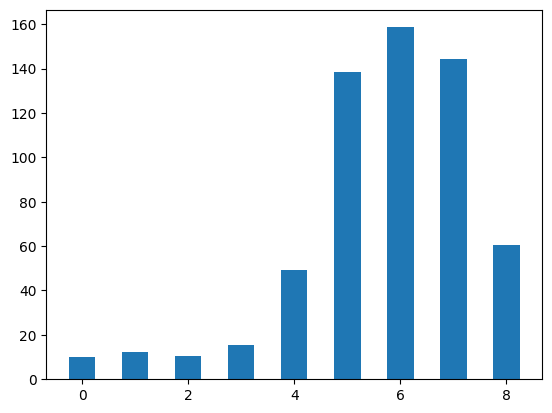

In [21]:
hist = df['hist'].loc[60][0][6]
plt.bar(np.arange(9), hist, width=0.5)

In [22]:
#df['L2_hist'] = df['hist'].apply(lambda x: normalize_histograms_L2(x, 2))

In [23]:
#l2_hist = df['hist'].loc[1][0]
#plt.bar(np.arange(36), l2_hist, width=0.5)

In [24]:
#df['feature_vector'] = df['L2_hist'].apply(lambda x: x.flatten())

### Klasyfikacje SVM

In [25]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
import numpy as np

X = np.array(df['f'].tolist())
Y = np.array(df['label'])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

svm_clf = SVC()

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear'],
    'gamma': ['scale', 'auto'],
}

grid_search = GridSearchCV(svm_clf, param_grid, cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train, Y_train)

print("Best Parameters:", grid_search.best_params_)

best_svm_clf = grid_search.best_estimator_

accuracy = best_svm_clf.score(X_test, Y_test)
print(f"Dokładność modelu na zbiorze testowym: {accuracy:.2f}")


Fitting 5 folds for each of 6 candidates, totalling 30 fits


/usr/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/pyth

Best Parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Dokładność modelu na zbiorze testowym: 1.00


In [26]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = best_svm_clf.predict(X_test)

print(classification_report(Y_test, y_pred))

print(confusion_matrix(Y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       291
           1       1.00      1.00      1.00       264

    accuracy                           1.00       555
   macro avg       1.00      1.00      1.00       555
weighted avg       1.00      1.00      1.00       555

[[291   0]
 [  0 264]]


In [27]:
df

,index,path,label,f,hist
0,1240,/home/plorenc/Desktop/AiR_ISS/AVS/pedestrians/...,1,"[0.2567444059941063, 0.10519139942995186, 0.05...","[[[946.2831237158354, 387.70405008512625, 206...."
1,1132,/home/plorenc/Desktop/AiR_ISS/AVS/pedestrians/...,1,"[0.20294475038955037, 0.09942562943590796, 0.0...","[[[151.55798518807975, 74.2504945037432, 53.96..."
2,1847,/home/plorenc/Desktop/AiR_ISS/AVS/pedestrians/...,1,"[0.20323318070175383, 0.08134343689144596, 0.0...","[[[813.8221755741727, 325.72974821874493, 226...."
3,1327,/home/plorenc/Desktop/AiR_ISS/AVS/pedestrians/...,1,"[0.19700435455613374, 0.20415010903689973, 0.2...","[[[433.20860202956453, 448.9219720006688, 462...."
4,410,/home/plorenc/Desktop/AiR_ISS/AVS/pedestrians/...,0,"[0.22479774386231824, 0.08154763720233191, 0.0...","[[[553.0974395736812, 200.6416459745163, 143.8..."
...,...,...,...,...,...
1844,150,/home/plorenc/Desktop/AiR_ISS/AVS/pedestrians/...,0,"[0.07720785401177022, 0.08428476586531122, 0.1...","[[[8.65211686009297, 9.445174368932413, 14.869..."
1845,733,/home/plorenc/Desktop/AiR_ISS/AVS/pedestrians/...,0,"[0.012964070487759695, 0.011176058982876894, 0...","[[[7.828595148798888, 6.748871137244165, 15.97..."
1846,1475,/home/plorenc/Desktop/AiR_ISS/AVS/pedestrians/...,1,"[0.12663675907194705, 0.11368575583553578, 0.1...","[[[224.1813558064986, 201.25457304713, 231.148..."
1847,1378,/home/plorenc/Desktop/AiR_ISS/AVS/pedestrians/...,1,"[0.282002262773015, 0.10743500229218592, 0.201...","[[[1286.6749501087158, 490.18729443846075, 918..."


In [28]:
cv2.imread(df['path'].loc[0]).shape

(128, 64, 3)

In [29]:
cv2.imread('/home/plorenc/Desktop/AiR_ISS/AVS/Test images-pedestrians/testImage1.png').shape

(498, 703, 3)

In [37]:
def resize_img(img, ratio = 1.5, window_size=(128, 64)):
    h, w = img.shape
    new_h, new_w = h//ratio, w//ratio

    if new_h < window_size[0] or new_w < window_size[1]:
        return img
    
    img = cv2.resize(img, (int(new_h), int(new_w)))

    return img

def compute_gradients(gray):
    '''
    Oblicza gradienty obrazu w skali szarości (magnitude + angle)
    '''
    gray = gray.astype(np.int32)

    # Gradienty w osi X i Y
    dx = convolve1d(gray, np.array([-1, 0, 1], dtype=np.float32), axis=1)
    dy = convolve1d(gray, np.array([-1, 0, 1], dtype=np.float32), axis=0)

    magnitude = np.sqrt(dx ** 2 + dy ** 2)
    angle = np.arctan2(dy, dx)
    angle[angle < 0] += np.pi  # zakres 0–π
    angle = np.rad2deg(angle)  # na stopnie

    return magnitude, angle

def detect_hog_svm(path, svm, window_size=(128, 64), overlap=0.5, clf_decision_function=True, threshold=0):
    gray_img = cv2.imread(path, cv2.IMREAD_COLOR_RGB)
    color_img = cv2.imread(path)

    desc = []
    ratio = 1

    step_y = int(window_size[0] * (1 - overlap))
    step_x = int(window_size[1] * (1 - overlap))

    pad_bottom = (-(gray_img.shape[0] - window_size[0]) % step_y) if gray_img.shape[0] >= window_size[0] else window_size[0] - gray_img.shape[0]
    pad_right = (-(gray_img.shape[1] - window_size[1]) % step_x) if gray_img.shape[1] >= window_size[1] else window_size[1] - gray_img.shape[1]

    gray_img = cv2.copyMakeBorder(gray_img, 0, pad_bottom, 0, pad_right, cv2.BORDER_CONSTANT, value=0)
    color_img = cv2.copyMakeBorder(color_img, 0, pad_bottom, 0, pad_right, cv2.BORDER_CONSTANT, value=(0, 0, 0))

    while gray_img.shape[0] >= window_size[0] and gray_img.shape[1] >= window_size[1]:
        for y in range(0, gray_img.shape[0] - window_size[0] + 1, step_y):
            for x in range(0, gray_img.shape[1] - window_size[1] + 1, step_x):
                window = gray_img[y:y + window_size[0], x:x + window_size[1]]

                #mag, angle = compute_gradients(window)
                #hist = create_hist(mag, angle)
                #hist = normalize_histograms_L2(hist).flatten()

                #plt.imshow(window)
                #plt.show()

                hist, _ = hog(window)

                if clf_decision_function:
                    # Użyj funkcji decyzyjnej i progu pewności
                    decision = svm.decision_function([hist])[0]
                    print(decision)
                    if decision > threshold:
                        print(f"Obiekt wykryty na pozycji: ({x}, {y}) z pewnością {decision:.2f}")
                        desc.append((ratio * x, ratio * y, window_size[0] * ratio, window_size[1] * ratio))
                else:
                    # Standardowe przewidywanie etykiety
                    if svm.predict([hist])[0] == 1:
                        print(f"Obiekt wykryty na pozycji: ({x}, {y})")
                        desc.append((ratio * x, ratio * y, window_size[0] * ratio, window_size[1] * ratio))

                display_img = color_img.copy()
                cv2.rectangle(display_img, (x, y), (x + window_size[1], y + window_size[0]), (0, 255, 0), 2)
                cv2.imshow('Sliding Window (scaled)', display_img)

                if cv2.waitKey(300) == 27:  # ESC
                    cv2.destroyAllWindows()
                    return desc

        new_h = int(gray_img.shape[0] // 1.5)
        new_w = int(gray_img.shape[1] // 1.5)

        if new_h < window_size[0] or new_w < window_size[1]:
            break

        gray_img = cv2.resize(gray_img, (new_w, new_h))
        color_img = cv2.resize(color_img, (new_w, new_h))
        ratio *= 1.5

    cv2.destroyAllWindows()
    return desc


In [42]:
#test_path = r'/home/plorenc/Desktop/AiR_ISS/AVS/Test images-pedestrians/testImage1.png'
test_path = r'/home/plorenc/Desktop/AiR_ISS/AVS/pedestrians/pos/per00001.ppm'


detect = detect_hog_svm(test_path, best_svm_clf)

cv2.destroyAllWindows()

1.3332382901156699
Obiekt wykryty na pozycji: (0, 0) z pewnością 1.33


In [32]:
cv2.destroyAllWindows()

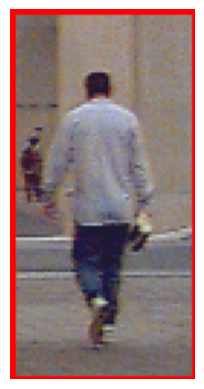

In [41]:
img = cv2.imread(test_path)
for (x, y, h, w) in detect:
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 2)


plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()
